In [1]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2


from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [12:10:31] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
# import master data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


In [3]:
### Import curated datasets:

e_coli_wild_perm = pd.read_pickle('data_curated/e_coli_wild_perm.pkl')
e_coli_wild_efflux = pd.read_pickle('data_curated/e_coli_wild_efflux.pkl')
e_coli_wild = pd.read_pickle('data_curated/e_coli_wild.pkl')
e_coli_s_aureus = pd.read_pickle('data_curated/e_coli_s_aureus.pkl')

# import substrate and evader

efflux_substrate = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_efflux']>65)&(e_coli_wild_efflux['INHIB_AVE_wild']<65)]

efflux_evader = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')
rest_of_ecoli_efflux= pd.read_pickle('data_curated/rest_of_ecoli_efflux.pkl')


### Import MMPA result:

# efflux_mmpa_index = pd.read_csv('out/index_co_add_wild_efflux_final.csv')

efflux_mmpa_index = pd.read_pickle('data_curated/efflux_mmpa_index.pkl')

efflux_mmpa_index_len_stat = pd.read_pickle('data_curated/efflux_mmpa_index_len_stat.pkl')

ecoli_wild_index=pd.read_csv('data_curated/index_inhib_wild_final.csv')


## relevant transforms:

substrate_transforms = pd.read_pickle('data_curated/substrate_transforms.pkl')

evader_transforms = pd.read_pickle('data_curated/evader_transforms.pkl')


efflux_substrate = pd.read_pickle('data_curated/efflux_substrate.pkl')
efflux_evader= pd.read_pickle('data_curated/efflux_evader.pkl')
wt_only= pd.read_pickle('data_curated/wt_only.pkl')
inactive= pd.read_pickle('data_curated/inactive.pkl')
sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')


In [4]:
e_coli_wild_perm['mol'] = e_coli_wild_perm.SMILES.apply(Chem.MolFromSmiles)

RDKit ERROR: [12:11:25] Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit ERROR: [12:11:32] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [12:11:32] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [12:11:32] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [12:11:32] Explicit valence for atom # 0 B, 6, is greater than permitted
RDKit ERROR: [12:11:32] Explicit valence for atom # 0 C, 6, is greater than permitted


In [5]:
e_coli_wild_perm.dropna(subset=['mol'], inplace=True)

In [6]:
e_coli_wild_perm['SMILES'] = e_coli_wild_perm.mol.apply(Chem.MolToSmiles)

In [7]:
e_coli_wild_perm['SMILES'] = e_coli_wild_perm['SMILES'].apply(Chem.CanonSmiles)

In [8]:
# z-score:

e_coli_wild_perm['wild_stds'] = stats.zscore(e_coli_wild_perm.INHIB_AVE_wild)
e_coli_wild_perm['lpxc_stds'] = stats.zscore(e_coli_wild_perm.INHIB_AVE_lpxC)

In [9]:
threshold = 4

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_perm['wild_class'] = e_coli_wild_perm.apply(label_it, axis=1)

In [10]:
def label_it(row):
    if row['lpxc_stds'] >=threshold:
        return 'active'
    if row['lpxc_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_perm['lpxc_class'] = e_coli_wild_perm.apply(label_it, axis=1)

In [11]:
e_coli_wild_perm.lpxc_class.value_counts()

inactive    80024
active        590
Name: lpxc_class, dtype: int64

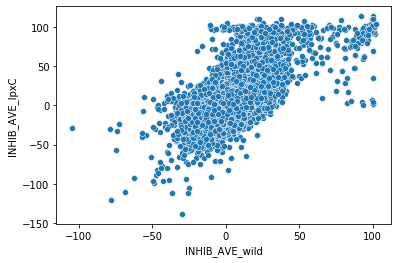

In [12]:
sns.scatterplot(data = e_coli_wild_perm, x = 'INHIB_AVE_wild', y = 'INHIB_AVE_lpxC')

In [12]:
def label_substrate(row):
    if row['lpxc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'OM non-Permeating'
    if row['lpxc_class'] == 'active' and row['wild_class'] == 'active':
        return 'OM Permeating'
    if row['lpxc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['lpxc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'
    
e_coli_wild_perm['Class'] = e_coli_wild_perm.apply(label_substrate, axis=1)

In [13]:
e_coli_wild_perm.Class.value_counts()

Inactive             79974
OM non-Permeating      369
OM Permeating          221
WT-only Active          50
Name: Class, dtype: int64

In [15]:
e_coli_wild_perm[e_coli_wild_perm.wild_stds >3.99 ].sort_values(by='wild_stds')

,SMILES,INHIB_AVE_wild,INHIB_AVE_lpxC,mol,wild_stds,lpxc_stds,wild_class,lpxc_class,Class
28505,N=C1SCC(=O)N1c1nccs1,41.87,69.96,"<img data-content=""rdkit/molecule"" src=""data:i...",3.995373,4.589357,inactive,active,OM Impermeable
54750,CCCC(C)c1ccc(O)c(/N=C/c2cc(Br)cc(Cl)c2O)c1,42.08,70.44,"<img data-content=""rdkit/molecule"" src=""data:i...",4.017447,4.623598,active,active,OM Permeable
55601,COCc1cc(C)nc(SCC[N+](C)(C)CC(=O)Nc2cccc(C(F)(F...,42.19,58.64,"<img data-content=""rdkit/molecule"" src=""data:i...",4.029010,3.781837,active,inactive,WT-only Active
71825,Cc1cc(C)c2nc3nc(C)cc(C)c3c(N)c2c1,42.19,70.84,"<img data-content=""rdkit/molecule"" src=""data:i...",4.029010,4.652133,active,active,OM Permeable
38545,Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@...,42.20,41.83,"<img data-content=""rdkit/molecule"" src=""data:i...",4.030061,2.582684,active,inactive,WT-only Active
...,...,...,...,...,...,...,...,...,...
30861,Br.CCCCCCCCCCn1ccc(=N)cc1,101.08,92.79,"<img data-content=""rdkit/molecule"" src=""data:i...",10.219313,6.217952,active,active,OM Permeable
23724,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,101.15,100.21,"<img data-content=""rdkit/molecule"" src=""data:i...",10.226671,6.747263,active,active,OM Permeable
73795,O=[N+]([O-])c1ccc(C=[N+]([O-])CCO)o1,101.33,101.04,"<img data-content=""rdkit/molecule"" src=""data:i...",10.245592,6.806471,active,active,OM Permeable
23441,CSC1SCC2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4...,101.44,90.80,"<img data-content=""rdkit/molecule"" src=""data:i...",10.257155,6.075993,active,active,OM Permeable


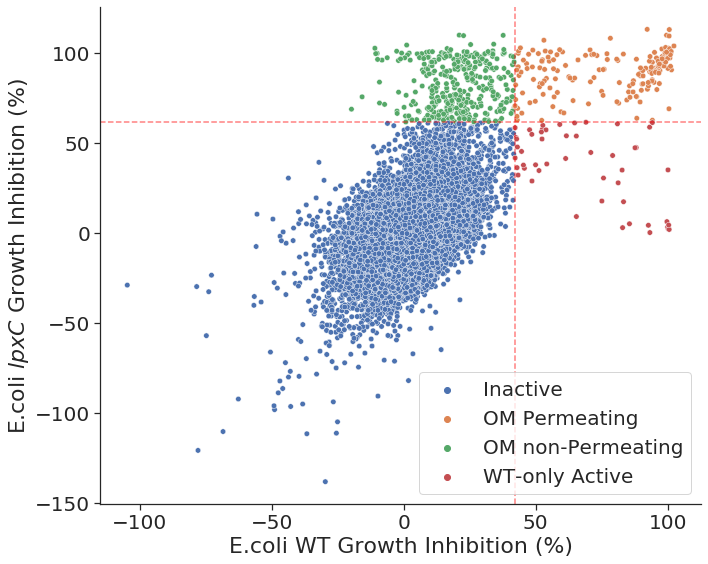

In [29]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])

sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style("ticks")

sns.scatterplot(data = e_coli_wild_perm, x='INHIB_AVE_wild', y='INHIB_AVE_lpxC', hue='Class', s=30)

sns.despine()

plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('E.coli WT Growth Inhibition (%)', fontsize=22);

plt.ylabel('E.coli $lpxC$ Growth Inhibition (%)',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axvline(x=42.08,  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=61.83,  color='red', linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('figures/wild_lpxc_class_scatter.png', dpi=600)

In [14]:
om_permeating = e_coli_wild_perm[e_coli_wild_perm['Class'] == 'OM Permeating']

om_non_permeating =  e_coli_wild_perm[e_coli_wild_perm['Class'] == 'OM non-Permeating']

om_inactive = e_coli_wild_perm[e_coli_wild_perm['Class'] == 'Inactive']

wt_active_only = e_coli_wild_perm[e_coli_wild_perm['Class'] == 'WT-only Active']


In [15]:
om_inactive.dropna(subset=['SMILES'], inplace=True)

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
om_permeable

,SMILES,INHIB_AVE_wild,INHIB_AVE_lpxC,mol,wild_stds,lpxc_stds,wild_class,lpxc_class,Class
10,OB1OCc2ccccc21,85.18,78.55,"<img data-content=""rdkit/molecule"" src=""data:i...",8.547963,5.202131,active,active,OM Permeable
28,BrC(/C=N/Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=C/c1cc...,88.28,75.90,"<img data-content=""rdkit/molecule"" src=""data:i...",8.873824,5.013091,active,active,OM Permeable
1215,Cl.Clc1ccc(C(=C2CN3CCC2CC3)c2ccc(Cl)s2)s1,57.46,85.84,"<img data-content=""rdkit/molecule"" src=""data:i...",5.634137,5.722168,active,active,OM Permeable
1229,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,70.60,101.91,"<img data-content=""rdkit/molecule"" src=""data:i...",7.015366,6.868533,active,active,OM Permeable
5124,O=C(N/N=C/c1ccc(O)c2ncccc12)c1ccco1,42.39,82.44,"<img data-content=""rdkit/molecule"" src=""data:i...",4.050033,5.479627,active,active,OM Permeable
...,...,...,...,...,...,...,...,...,...
77567,Cc1nnn(-c2nonc2N)c1C(=O)N/N=C/c1ccc([N+](=O)[O...,52.27,62.72,"<img data-content=""rdkit/molecule"" src=""data:i...",5.088583,4.072887,active,active,OM Permeable
77780,Brc1cnc2c(c1)Oc1ccccc1-c1cc(CN3CCOCC3)nn1-2,62.99,86.23,"<img data-content=""rdkit/molecule"" src=""data:i...",6.215431,5.749989,active,active,OM Permeable
78284,CN(C)c1nc(N/N=C/C(Br)=C/c2ccccc2)nc(N2CCOCC2)n1,96.66,89.02,"<img data-content=""rdkit/molecule"" src=""data:i...",9.754699,5.949016,active,active,OM Permeable
78826,COC1=C(N)C(=O)c2nc(-c3nc(C(=O)O)c(C)c(-c4ccc(O...,102.37,104.11,"<img data-content=""rdkit/molecule"" src=""data:i...",10.354913,7.025472,active,active,OM Permeable


In [26]:
om_permeating['SMILES'] = om_permeating['SMILES'].apply(Chem.CanonSmiles) 

om_non_permeating['SMILES'] = om_non_permeating['SMILES'].apply(Chem.CanonSmiles) 

om_inactive['SMILES'] = om_inactive['SMILES'].apply(Chem.CanonSmiles) 

# substrate_transforms['compound_structure_A'] = substrate_transforms['compound_structure_A'].apply(Chem.CanonSmiles) 

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_

In [27]:
om_permeating.to_pickle('data_curated/om_permeating.pkl')
om_non_permeating.to_pickle('data_curated/om_non_permeating.pkl')

## How many evaders are also permeators?

In [57]:
len(efflux_evader[efflux_evader['SMILES'].isin(om_permeating['SMILES'])])

186

In [58]:
len(efflux_evader[efflux_evader['SMILES'].isin(om_non_permeating['SMILES'])])

0

In [59]:
len(efflux_evader[efflux_evader['SMILES'].isin(om_inactive['SMILES'])])

1

In [60]:
len(efflux_evader[efflux_evader['SMILES'].isin(wt_active_only['SMILES'])])

14

In [61]:
len(efflux_evader)

200

In [94]:
data = [['OM Permeating', 186], ['OM non-Permeating', 0], ['OM inactive', 1], ['OM wt_active_only', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Outer membrane permeation', 'No. of Compounds'])

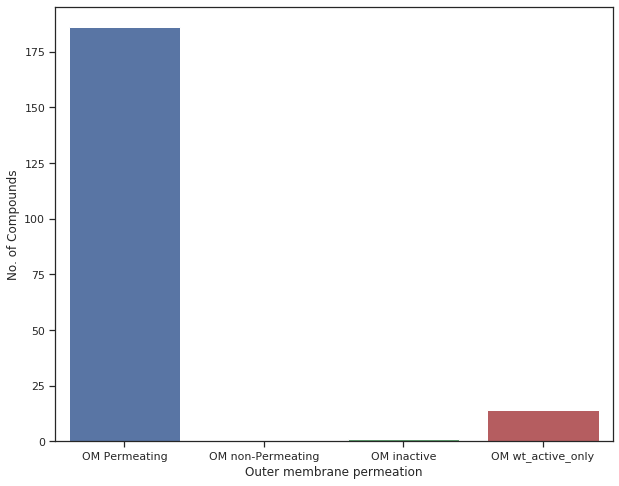

In [95]:
sns.barplot(data=df, x="Outer membrane permeation", y="No. of Compounds")
# ax.bar_label(ax.containers[0])

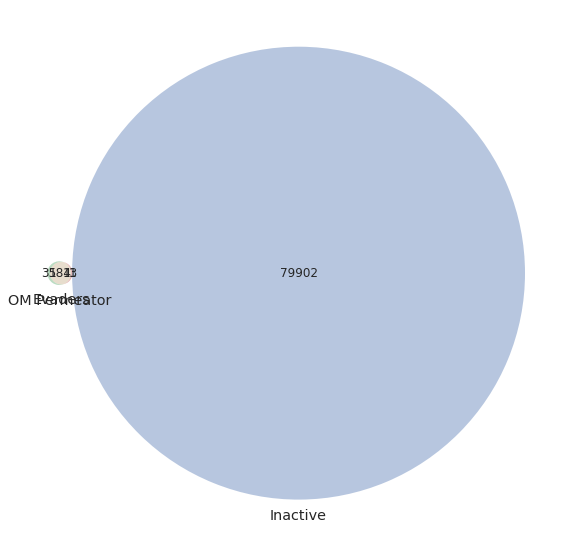

In [54]:
plt.figure(figsize=(10,10))

venn3([set(efflux_evader.SMILES.to_list()), 
      set(om_permeable.SMILES.to_list()),
      set(om_inactive.SMILES.to_list())],
       set_labels=('Evaders', 'OM Permeator', 'Inactive')
     )

Out of 200 efflux evaders 186 are permeators. 

## How many substrates are also non-permeators?

In [62]:
len(efflux_substrate[efflux_substrate['SMILES'].isin(om_permeating['SMILES'])])

5

In [63]:
len(efflux_substrate[efflux_substrate['SMILES'].isin(om_non_permeating['SMILES'])])

206

In [64]:
len(efflux_substrate[efflux_substrate['SMILES'].isin(om_inactive['SMILES'])])

548

In [65]:
len(efflux_substrate[efflux_substrate['SMILES'].isin(wt_active_only['SMILES'])])

2

In [49]:
len(efflux_substrate)

760

In [84]:
data = [['OM Permeating', 5], ['OM non-Permeating', 206], ['OM inactive', 548], ['OM wt_active_only', 2]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['OM', 'No. of Compounds'])

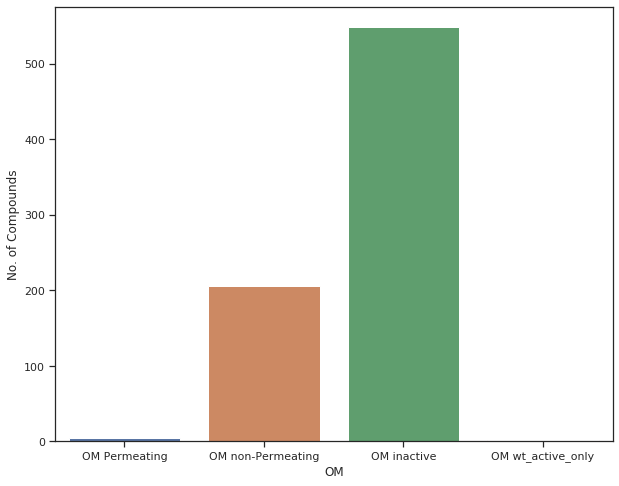

In [86]:
ax = sns.barplot(data=df, x="OM", y="No. of Compounds")
# ax.bar_label(ax.containers[0])

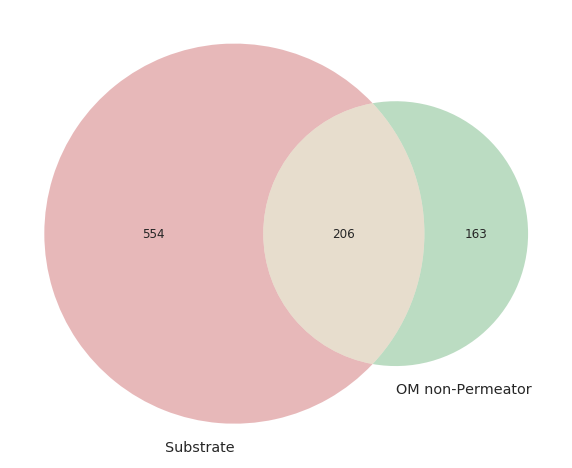

In [66]:
plt.figure(figsize=(10,10))

venn2([set(efflux_substrate.SMILES.to_list()), 
      set(om_non_permeating.SMILES.to_list())],
       set_labels=('Substrate', 'OM non-Permeator')
     )

## How many substrate transforms are also non-permeators?

In [17]:
substrate_transforms

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
2258,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54138,54140,[*:1]c1ccc(Br)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,14.87,66.49,51.62,[*:1]c1ccc(Br)cc1,[*:1]c1ccccc1
2259,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54139,54140,[*:1]c1ccc(F)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,47.29,66.49,19.20,[*:1]c1ccc(F)cc1,[*:1]c1ccccc1
3224,N#C/C(=C\c1c(F)cccc1Cl)c1nc2ccccc2[nH]1,Cl.N#C/C(=C\c1ccccc1[N+](=O)[O-])c1nc2ccccc2[nH]1,23016,58458,[*:1]c1c(F)cccc1Cl>>[*:1]c1ccccc1[N+](=O)[O-],[*:1]/C=C(\C#N)c1nc2ccccc2[nH]1,-11.20,80.96,92.16,[*:1]c1c(F)cccc1Cl,[*:1]c1ccccc1[N+](=O)[O-]
3245,N#C/C(=C\c1cc(Br)c(O)c(Br)c1O)c1nc2ccccc2[nH]1,Cl.N#C/C(=C\c1ccccc1[N+](=O)[O-])c1nc2ccccc2[nH]1,58389,58458,[*:1]c1cc(Br)c(O)c(Br)c1O>>[*:1]c1ccccc1[N+](=...,[*:1]/C=C(\C#N)c1nc2ccccc2[nH]1,1.32,80.96,79.64,[*:1]c1cc(Br)c(O)c(Br)c1O,[*:1]c1ccccc1[N+](=O)[O-]
3265,COc1c(Cl)cc(Cl)cc1/C=C(\C#N)c1nc2ccccc2[nH]1,Cl.N#C/C(=C\c1ccccc1[N+](=O)[O-])c1nc2ccccc2[nH]1,58391,58458,[*:1]c1cc(Cl)cc(Cl)c1OC>>[*:1]c1ccccc1[N+](=O)...,[*:1]/C=C(\C#N)c1nc2ccccc2[nH]1,-6.52,80.96,87.48,[*:1]c1cc(Cl)cc(Cl)c1OC,[*:1]c1ccccc1[N+](=O)[O-]
...,...,...,...,...,...,...,...,...,...,...,...
1405047,OCC1OC(n2cnc3c(O)ncnc32)C(O)C1O,OC[C@@H]1CC[C@H](n2cnc3c(O)ncnc32)O1,70480,38826,[*:1]C1OC(CO)C(O)C1O>>[*:1][C@H]1CC[C@@H](CO)O1,[*:1]n1cnc2c(O)ncnc21,-13.27,81.08,94.35,[*:1]C1OC(CO)C(O)C1O,[*:1][C@H]1CC[C@@H](CO)O1
1406560,O=[N+]([O-])c1ccc(-n2ncc3c([N+](=O)[O-])cc([N+...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63724,62159,[*:1]c1ccc([N+](=O)[O-])cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-19.26,80.56,99.82,[*:1]c1ccc([N+](=O)[O-])cc1,[*:1][H]
1406563,Cc1ccc(-n2ncc3c([N+](=O)[O-])cc([N+](=O)[O-])c...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63726,62159,[*:1]c1ccc(C)cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-14.22,80.56,94.78,[*:1]c1ccc(C)cc1,[*:1][H]
1406565,O=C(O)c1ccccc1-n1ncc2c([N+](=O)[O-])cc([N+](=O...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,70401,62159,[*:1]c1ccccc1C(=O)O>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-8.49,80.56,89.05,[*:1]c1ccccc1C(=O)O,[*:1][H]


In [21]:
len(substrate_transforms[substrate_transforms['compound_structure_B'].isin(om_non_permeating['SMILES'])])

3358

In [22]:
len(substrate_transforms)

7925

## How many substrate transforms are also non-permeators?

In [23]:
len(evader_transforms[evader_transforms['compound_structure_B'].isin(om_permeating['SMILES'])])

550

In [24]:
len(evader_transforms)

612